In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
import numpy as np
import xarray as xr
import netCDF4
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import cmocean
import matplotlib.image as mpimg
from IPython.display import Image, display
import cartopy.io.shapereader as shpreader
import cartopy.feature as cfeature
import matplotlib.gridspec as gridspec
%matplotlib inline

from modules.plotter import simple_xarray_contour_map, loadCPT, make_cmap
from modules import nclcmaps

### Fig 1a - Lightning jpg

In [2]:
image=mpimg.imread('../data/lightning_square.jpg')

# plt.axis("off")
# plt.imshow(image)
# cur_axes = plt.gca()
# cur_axes.axes.get_xaxis().set_ticklabels([])
# cur_axes.axes.get_yaxis().set_ticklabels([])
# cur_axes.axes.get_xaxis().set_ticks([])
# cur_axes.axes.get_yaxis().set_ticks([])
# plt.show()

### Fig 1b Precip Accumulation and Hail Locations

In [3]:
## NOAA SWDI Hail Locations 6 March 2019 ##

## location and name of txt file
filename = '../data/NOAA_SWDI/swdiws_nx3hail_all_20190306_bbox_-131_31_-116_41.csv'
# filename = '/home/sbarc/students/nash/data/NOAA_SWDI/noaa_swdi_hail_030602019_retrieved03102020.csv'
df = pd.read_csv(filename, header=0, parse_dates=['ZTIME'])
df = df.replace(-999, np.NaN)
x_hail = df.LON
y_hail = df.LAT
df['MAXSIZE'] = df['MAXSIZE']*25.4 ## convert from inches to mm
# df

print('Average hail size:', df.MAXSIZE.mean(), 'mm')
print('Max hail size:', df.MAXSIZE.max(), 'mm')

Average hail size: 13.548815566836103 mm
Max hail size: 44.449999999999996 mm


In [4]:
### NOAA NEXRAD L3 RADAR Vandenburg
filename_pattern = '../data/NWS_N1P_NEXRAD_NXL3/netcdf/KVBX*.nc'
ds_KVBX = xr.open_mfdataset(filename_pattern, combine='by_coords')
ds_KVBX = ds_KVBX.sel(lat=slice(32, 42), lon=slice(-125., -115.))

### NOAA NEXRAD L3 RADAR LA
filename_pattern = '../data/NWS_N1P_NEXRAD_NXL3/netcdf/KVTX*.nc'
ds_KVTX = xr.open_mfdataset(filename_pattern, combine='by_coords')
ds_KVTX = ds_KVBX.sel(lat=slice(32, 42), lon=slice(-125., -115.))

def calc_accum_precip(ds):
    '''
    calculate accumulated precip
    Precip from radar is in est. precip accumulation (in) in one hour, measured every ~5 min
    Need to convert to precip accumulated each minute measured each 5 minutes
    divide by 60 (minutes in an hour) and multiply by 5 minutes
    multiply by 25.4 to covert from inches to mm
    '''

    ## Calculate the difference in time
    dt = ds.time.diff(dim='time')
    dt = dt.values.astype('timedelta64[s]')
    dt = (dt / np.timedelta64(1,'s')).astype('int64')
    ntime, nlat, nlon = ds.ohp.shape
    dt1 = np.repeat(dt, nlat*nlon).reshape((ntime-1, nlat, nlon))
    y2 = ((ds.ohp[:-1, :, :].fillna(0).values*25.4)/60.0)*(dt1/60.0)

    precip_final = np.sum(y2, axis=0)
    return precip_final

precip_final_KVBX = calc_accum_precip(ds_KVBX)
precip_final_KVTX = calc_accum_precip(ds_KVTX)

In [5]:
ds_precip = xr.Dataset({'precip_accum': (['lat', 'lon'], precip_final_KVBX)},
                        coords={'lat': (['lat'], ds_KVBX.lat),
                                'lon': (['lon'], ds_KVBX.lon)})
# Total accumulated over SB
SB_precip_total = ds_precip.sel(lat=[34.42611], lon=[-119.84361], method='nearest')
print('Total accumulated in SB:', SB_precip_total.values, 'mm')

Total accumulated in SB: <bound method Mapping.values of <xarray.Dataset>
Dimensions:       (lat: 1, lon: 1)
Coordinates:
  * lat           (lat) float64 34.42
  * lon           (lon) float64 -119.8
Data variables:
    precip_accum  (lat, lon) float64 23.18> mm


### Fig 1c - Lightning Strikes 6 March 2019

In [6]:
## Import Lightning Strike Data ##
filename = '../data/ENTLN/ENTLN_flashes_-_UC_Santa_Barbara_030419_00UTC_to_030819_00UTC_flash20190306.csv'
df_lightning = pd.read_csv(filename, header=0, parse_dates=['timestamp'])
df_lightning
df_lightning['freq'] = df_lightning.icmultiplicity + df_lightning.cgmultiplicity

In [7]:
filename = '../data/ENTLN/ENTLN_flashes_-_UC_Santa_Barbara_030419_00UTC_to_030819_00UTC_flash_combined.csv'
df_l1 = pd.read_csv(filename, header=0, parse_dates=['timestamp'])
df_l1['freq'] = df_l1.icmultiplicity + df_l1.cgmultiplicity

#greater than the start date and smaller than the end date
mask = (df_l1['timestamp'] >= '2019-03-05-12') & (df_l1['timestamp'] <= '2019-03-06-18')
space_mask = (df_l1['latitude'] >=30.) & (df_l1['latitude'] <=37.0) & (df_l1['longitude'] >= -130.) & (df_l1['longitude'] <=-115.)
lightning_event = df_l1.loc[mask&space_mask]
print('Total # of lightning pulses in 30 hours of event:', lightning_event.freq.sum())
print('Total # of lightning flashes in 30 hours of event:', lightning_event.freq.count())

Total # of lightning pulses in 30 hours of event: 85032
Total # of lightning flashes in 30 hours of event: 46222


In [8]:
latitude_bins = np.arange(20.0, 50.1, 0.1)
longitude_bins = np.arange(-140.0, -109.9, 0.1)

latitude_group= pd.cut(df_lightning['latitude'], bins=latitude_bins)
longitude_group= pd.cut(df_lightning['longitude'], bins=longitude_bins)

new_df = df_lightning.groupby([(latitude_group), (longitude_group)]).sum()
lightning_count = new_df['freq'].values
lightning_count = lightning_count.reshape((latitude_bins.size-1, longitude_bins.size-1))

In [9]:
## Read all data into single xarray dataset 
ds_lightning = xr.Dataset({'freq': (['lat', 'lon'], lightning_count)},
                coords={'lat': (['lat'], latitude_bins[:-1]),
                        'lon': (['lon'], longitude_bins[:-1])})


## Find location of maximum count
da_max_freq = ds_lightning.freq.where(ds_lightning.freq==ds_lightning.freq.max(), drop=True).squeeze()
da_max_freq

<xarray.DataArray 'freq' ()>
array(933.)
Coordinates:
    lat      float64 37.6
    lon      float64 -120.6

### Fig 1d - Lightning Climatology with Lightning points 4 - 5 UTC

In [10]:
## Import Lightning Climatology Monthly Data ##
filename = '../data/TRMM_LIS-OTD/LISOTD_HRMC_V2.3.2015.nc'
# filename = '/home/sbarc/students/nash/data/TRMM_LIS-OTD/LISOTD_LRFC_V2.3.2015.nc'
lightning_clim_ds = xr.open_dataset(filename, decode_times=False)
# lightning_clim = lightning_clim_ds.HRFC_COM_FR
# lightning_clim = lightning_clim_ds.LRFC_COM_FR
lightning_clim = lightning_clim_ds.HRMC_COM_FR

### Get area of gridcells
filename = '../data/TRMM_LIS-OTD/LISOTD_HRFC_V2.3.2015.nc'
lightning_clim_ds2 = xr.open_dataset(filename, decode_times=False)
clim_area = lightning_clim_ds2.HRFC_AREA ## area of each grid cell km^2

lightning_clim_new = (lightning_clim * clim_area) ## convert to count/day
lightning_clim_new.attrs['units'] = 'count/day'

mon=8
print('Average Flash Density', lightning_clim.sel(Latitude=slice(30, 40), Longitude=slice(-125.0, -115.0), Month=mon).mean().values,
     lightning_clim.units)

print('Average Flash Density', lightning_clim_new.sel(Latitude=slice(30, 40), Longitude=slice(-125.0, -115.0), Month=mon).mean().values,
     lightning_clim_new.units)

print('Average Flash Density', lightning_clim.sel(Latitude=slice(20, 50), Longitude=slice(-140.0, -110.0), Month=mon).mean().values,
     lightning_clim.units)

print('Average Flash Density', lightning_clim_new.sel(Latitude=slice(20, 50), Longitude=slice(-140.0, -110.0), Month=mon).mean().values,
     lightning_clim_new.units)

Average Flash Density 0.0068721576 count/km^2/day
Average Flash Density 17.23187 count/day
Average Flash Density 0.013441332 count/km^2/day
Average Flash Density 32.993103 count/day


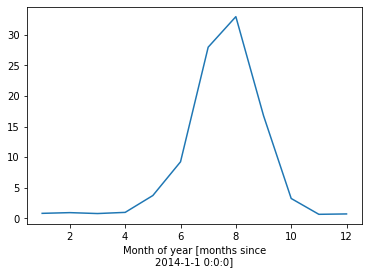

In [11]:
lightning_clim_new.sel(Latitude=slice(20, 50), Longitude=slice(-140.0, -110.0)).mean(dim=['Latitude', 'Longitude']).plot()

In [12]:
## Import Lightning Climatology Data ##
filename = '../data/TRMM_LIS-OTD/LISOTD_HRFC_V2.3.2015.nc'
# filename = '/home/sbarc/students/nash/data/TRMM_LIS-OTD/LISOTD_LRFC_V2.3.2015.nc'
lightning_clim_ds = xr.open_dataset(filename, decode_times=False)
lightning_clim = lightning_clim_ds.HRFC_COM_FR
# lightning_clim = lightning_clim_ds.LRFC_COM_FR

clim_area = lightning_clim_ds.HRFC_AREA ## area of each grid cell km^2
# clim_area = lightning_clim_ds.LRFC_AREA ## area of each grid cell km^2

lightning_clim_new = (lightning_clim * clim_area)/365.25 ## convert to count/day
lightning_clim_new.attrs['units'] = 'count/day'

print('Average Flash Density', lightning_clim.sel(Latitude=slice(30, 37), Longitude=slice(-130.0, -115.0)).mean().values,
     lightning_clim.units)

print('Average Flash Density', lightning_clim_new.sel(Latitude=slice(30, 37), Longitude=slice(-130.0, -115.0)).mean().values,
     lightning_clim_new.units)

Average Flash Density 0.47721258 count/km^2/year
Average Flash Density 3.3405929 count/day


In [13]:
#greater than the start date and smaller than the end date
mask = (df_lightning['timestamp'] > '2019-03-06-04') & (df_lightning['timestamp'] <= '2019-03-06-05')
lightning_6mar19_4UTC = df_lightning.loc[mask]

print('Max Lat:', lightning_6mar19_4UTC.latitude.max())
print('Min Lat:', lightning_6mar19_4UTC.latitude.min())
print('Max Lon:', lightning_6mar19_4UTC.longitude.max())
print('Min Lon:', lightning_6mar19_4UTC.longitude.min())

Max Lat: 36.01961
Min Lat: 30.98787
Max Lon: -117.77003
Min Lon: -123.38706


### Figure 1 Final

./figures/f1.png


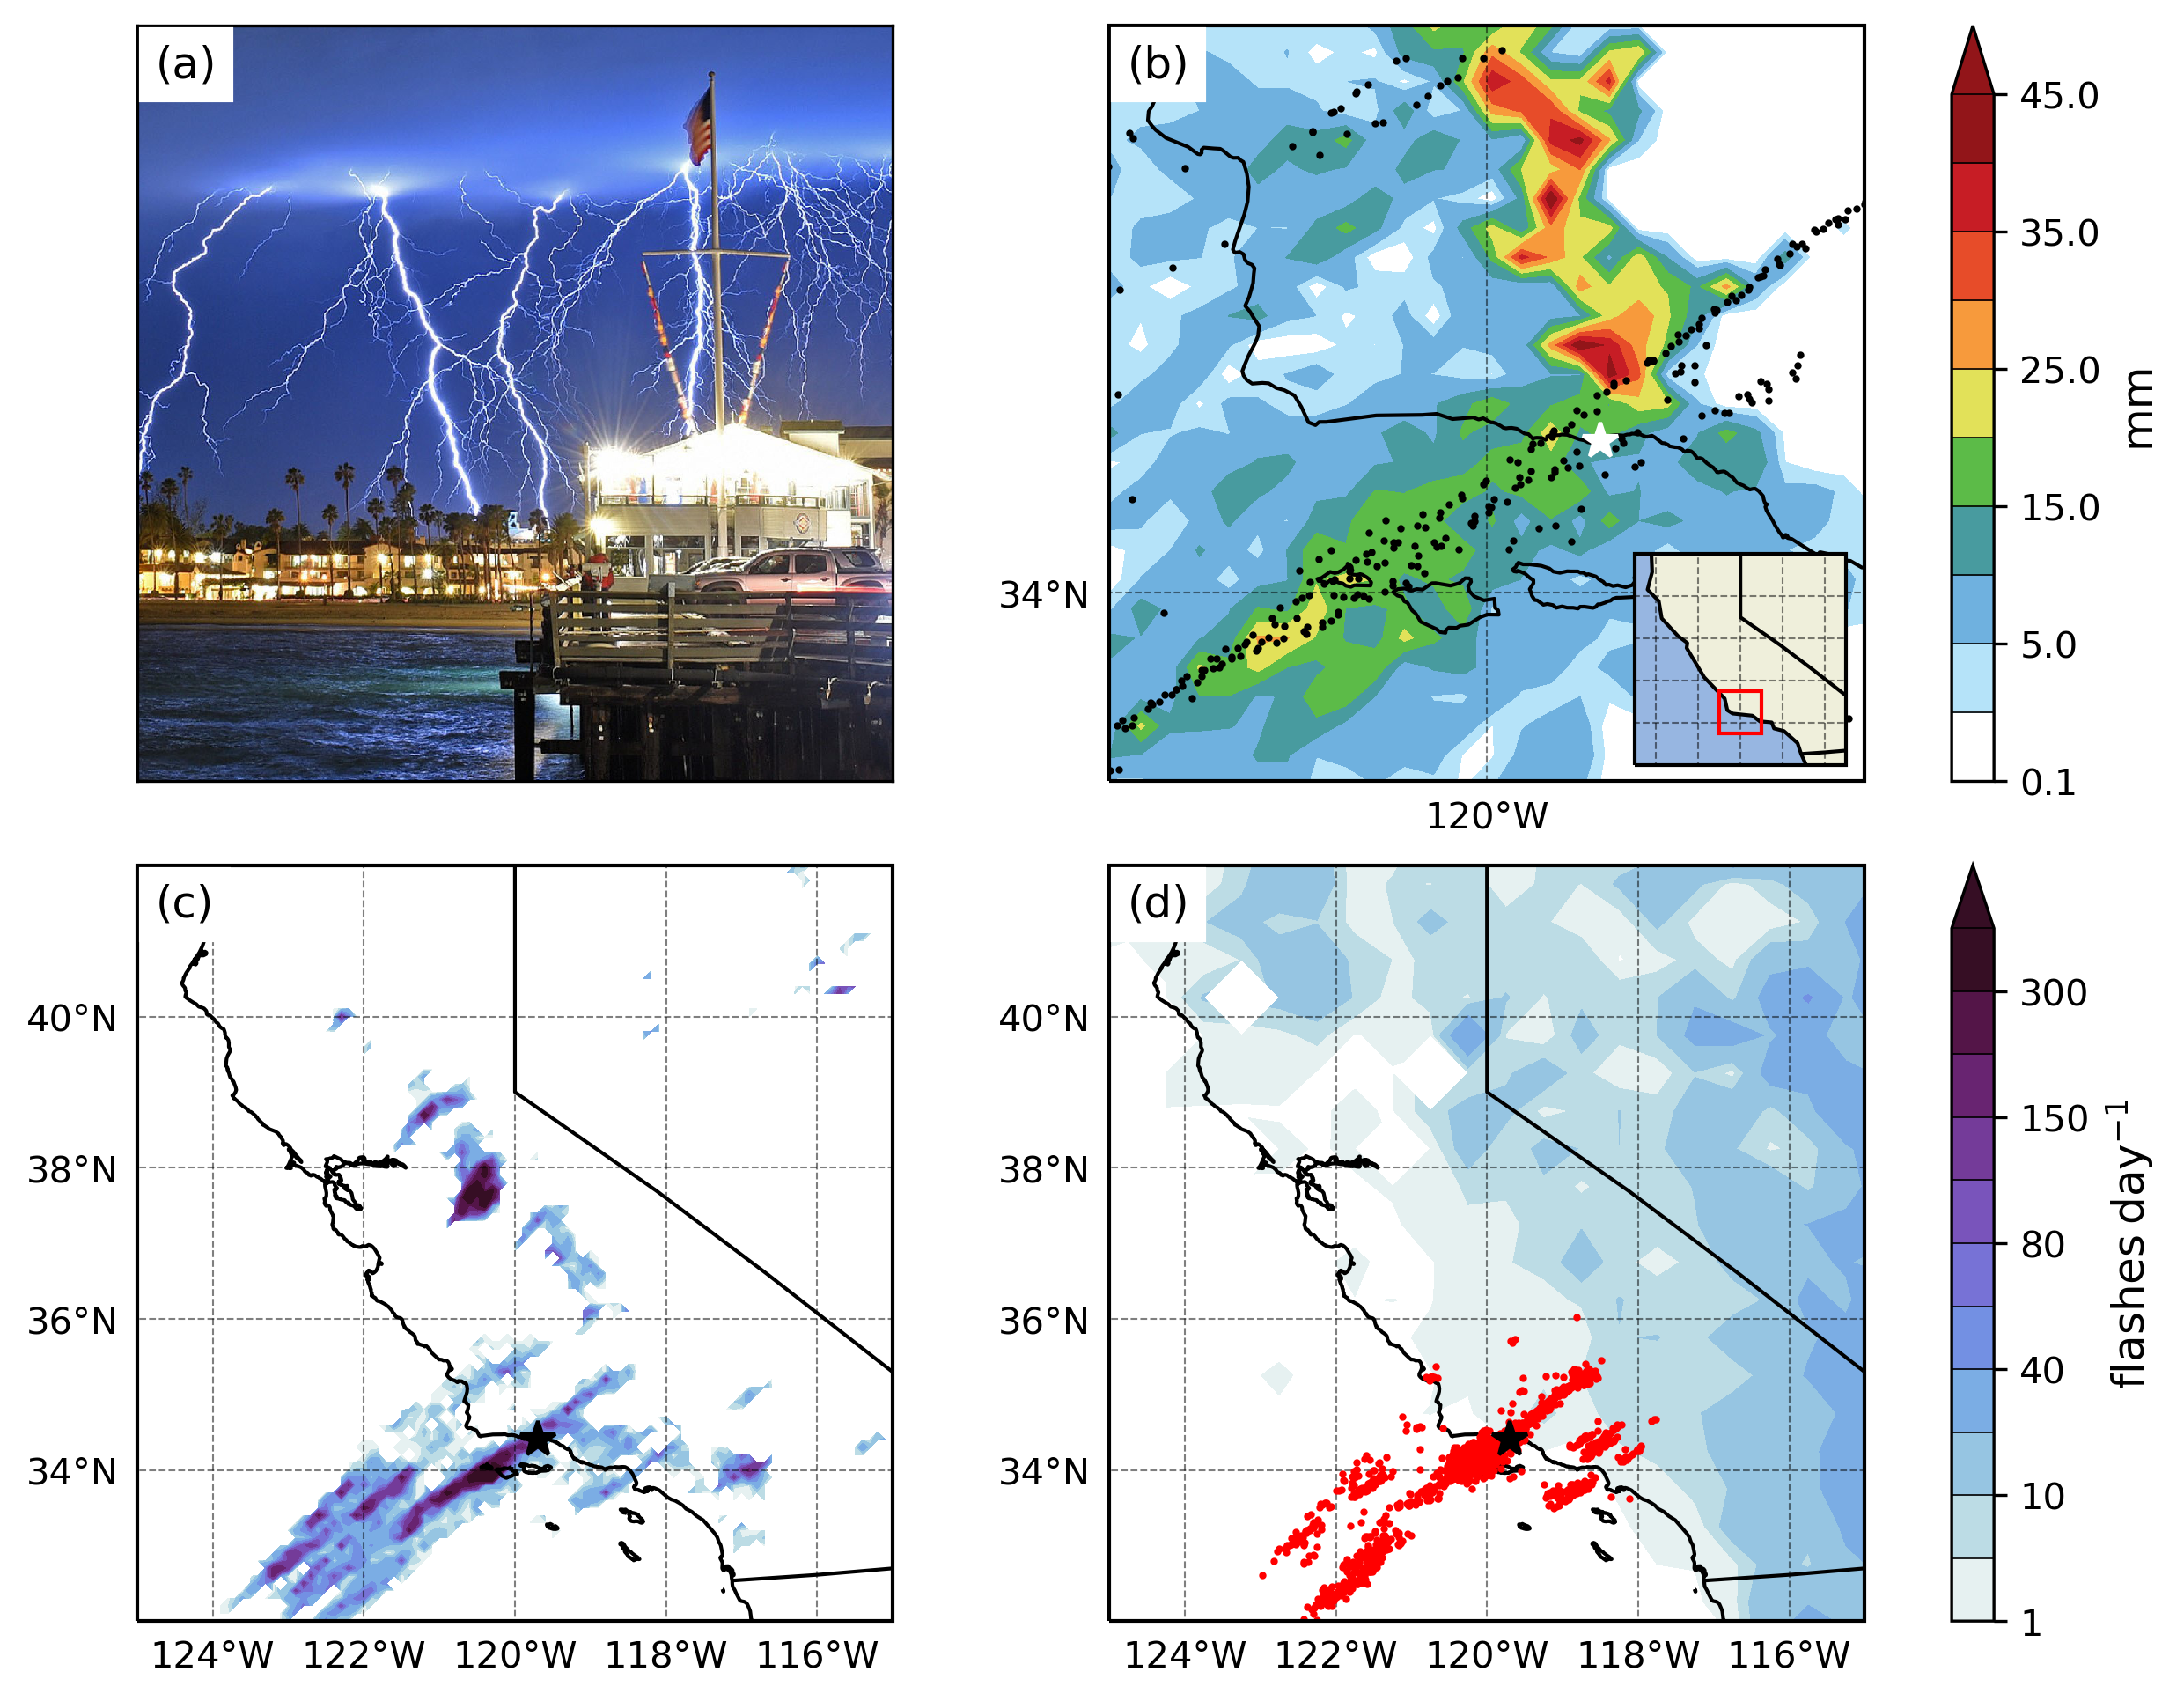

<Figure size 2400x2400 with 0 Axes>

In [21]:
## All plots together
## figsize=(width,height (inches))
fig = plt.figure(figsize=(8.,8.))
fig.dpi = 300
fname = './figures/f1'
fmt1 = 'png'
fmt2 = 'pdf'

## Map Information
ext1 = (-119.0, -121.0, 33.5, 35.5) ## zoomed in to SB
# ext = (-117.5, -123.5, 30.0, 36.0) ## central coast
ext = (-115.0, -125.0, 32.0, 42.0)
datacrs = ccrs.PlateCarree()
mapcrs = ccrs.PlateCarree()

## Figure Grid
## Use gridspec to set up a plot with a series of subplots that is
## n-rows by n-columns
## gs[rows index, columns index]
# gs = gridspec.GridSpec(numrows, numcols, hspace=0.2, wspace=0.1)
gs = fig.add_gridspec(nrows=4, ncols=4, hspace=0.25, wspace=0.001, left=0.05, right=0.97)
gs1 = fig.add_gridspec(nrows=4, ncols=1, hspace=0.25, wspace=0.01, left=0.96, right=0.98)

# Create a feature for States/Admin 1 regions at 1:50m from Natural Earth
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')

## Colormap information
lightning_cmap2 = cmocean.cm.dense
lightning_clevs2 = [1, 5, 10, 20, 40, 60, 80, 100, 150, 200, 300, 400]
lightning_norm2 = mcolors.BoundaryNorm(lightning_clevs2, lightning_cmap2.N)

cmap = nclcmaps.cmap('WhiteBlueGreenYellowRed')
# clevs = [0.1, 6, 12, 25, 35, 45, 55, 65, 75, 100, 125] # GPM
clevs = [0.1, 2., 5., 10., 15., 20., 25., 30., 35., 40., 45.] # NWS
norm = mcolors.BoundaryNorm(clevs, cmap.N)

################################
# Plot Fig1a - lightning image #
################################

ax3 = fig.add_subplot(gs[:2, :2])
# ax3.axis("off")
ax3.imshow(image)
cur_axes = plt.gca()
ax3.get_xaxis().set_ticklabels([])
ax3.get_yaxis().set_ticklabels([])
ax3.get_xaxis().set_ticks([])
ax3.get_yaxis().set_ticks([])
# plt.title('(c)', fontsize=12, loc='left')
plt.annotate('(a)', (5, 192), xycoords='axes points', fontsize=12.,
            backgroundcolor='white')


#######################################################
# Plot Fig1b - Precip Accumulation and Hail Locations #
#######################################################
KVBX_lat = ds_KVBX.lat.values
KVBX_lon = ds_KVBX.lon.values

ax4 = fig.add_subplot(gs[:2, 2:], projection=datacrs)
ax4.set_extent(ext1, crs=datacrs)

cf = ax4.contourf(KVBX_lon, KVBX_lat, precip_final_KVBX, transform=datacrs, 
                 cmap=cmap, norm=norm, levels=clevs, extend='max')

cf2 = ax4.contourf(ds_KVTX.lon.values, ds_KVTX.lat.values, precip_final_KVTX, transform=datacrs, 
                  cmap=cmap, norm=norm, levels=clevs, extend='max')

ax4.plot(x_hail, y_hail, 'ko', markersize=1, transform=ccrs.PlateCarree())


gl = ax4.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=.5, color='black', alpha=0.5, linestyle='--')
gl.xlocator = mticker.FixedLocator(np.arange(-126., -112., 2))
gl.ylocator = mticker.FixedLocator(np.arange(30, 44, 2))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabels_top = False
gl.ylabels_right = False

# Plot Santa Barbara Star
ax4.plot(-119.7, 34.4, 'w*', markersize=10, transform=mapcrs)

# Add Border Features
ax4.coastlines(linewidths=1.0, resolution='10m')
ax4.add_feature(states_provinces, edgecolor='k')
ax4.add_feature(cfeature.BORDERS)

# plt.title('(d)', fontsize=12, loc='left')
plt.annotate('(b)', (5, 192), xycoords='axes points', fontsize=12.,
            backgroundcolor='white')

### Add inset map
axins = plt.axes([0.81, 0.53, 0.1, 0.1], projection=mapcrs)
axins.set_extent(ext, crs=mapcrs)
# Add Border Features
# coast = axins.coastlines(linewidths=1.0, resolution='10m')
axins.add_feature(cfeature.OCEAN)
axins.add_feature(cfeature.LAND, edgecolor='black')
axins.add_feature(states_provinces, edgecolor='k')
axins.add_feature(cfeature.BORDERS)

gl = axins.gridlines(crs=datacrs, draw_labels=True,
                  linewidth=.5, color='black', alpha=0.5, linestyle='--')
gl.xlocator = mticker.FixedLocator(np.arange(-126., -112., 2))
gl.ylocator = mticker.FixedLocator(np.arange(30, 44, 2))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabels_top = False
gl.xlabels_bottom = False
gl.ylabels_right = False
gl.ylabels_left = False

axins.add_patch(mpatches.Rectangle(xy=[-121., 33.5], width=2, height=2,
                                    fill=False,
                                    edgecolor='r',
                                    linewidth=1.0,
                                    transform=mapcrs,
                                    zorder=101))


########################
# Plot Precip Colorbar #
########################
# Add color bar
cax2 = fig.add_subplot(gs1[:2, :])
cbar = fig.colorbar(cf, cax=cax2, drawedges=True, 
                    orientation='vertical', extendfrac='auto', shrink=0.8)
cbar.ax.set_ylabel('mm', fontsize=12)


################################################
# Plot Fig1c -  Lightning Strikes 6 March 2019 #
################################################

ax2 = fig.add_subplot(gs[2:, :2], projection=datacrs)
ax2.set_extent(ext, crs=datacrs)

cf = ax2.contourf(longitude_bins[:-1], latitude_bins[:-1], 
                 lightning_count, transform=mapcrs, extend='max',
                 cmap=lightning_cmap2, norm=lightning_norm2, levels=lightning_clevs2)

gl = ax2.gridlines(crs=mapcrs, draw_labels=True,
                  linewidth=.5, color='black', alpha=0.5, linestyle='--')
gl.xlocator = mticker.FixedLocator(np.arange(-126., -112., 2))
gl.ylocator = mticker.FixedLocator(np.arange(30, 44, 2))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabels_top = False
gl.ylabels_right = False

# Plot Santa Barbara Star
ax2.plot(-119.7, 34.4, 'k*', markersize=10, transform=mapcrs)

# Add Border Features
ax2.coastlines(linewidths=1.0, resolution='10m')
ax2.add_feature(states_provinces, edgecolor='k')
ax2.add_feature(cfeature.BORDERS)

# plt.title('(b)', fontsize=12, loc='left')
plt.annotate('(c)', (5, 192), xycoords='axes points', fontsize=12.,
            backgroundcolor='white')


#######################################################################
# Plot Fig1d -  Lightning Climatology with Lightning points 4 - 5 UTC #
#######################################################################

ax1 = fig.add_subplot(gs[2:, 2:], projection=datacrs)
ax1.set_extent(ext, crs=datacrs)

## Plot Lightning Strike Locations for 6 March 2019 4-5 UTC ##
ax1.plot(lightning_6mar19_4UTC.longitude, lightning_6mar19_4UTC.latitude,
        'ro', markersize=1, transform=mapcrs)

## Filled Contour Plot of Lightning Clim ##
cf = ax1.contourf(lightning_clim_new.Longitude, lightning_clim_new.Latitude, lightning_clim_new,
                 transform=mapcrs, extend='max', 
                 cmap=lightning_cmap2, norm=lightning_norm2, levels=lightning_clevs2)

# cbar = fig.colorbar(cf, ax=ax1, extend='neither', orientation='vertical')
# cbar.ax.set_ylabel('$\mathrm{flashes \: day^{-1}}$', fontsize=12)

# Plot Santa Barbara Star
ax1.plot(-119.7, 34.4, 'k*', markersize=10, transform=mapcrs)

# Add Border Features
ax1.coastlines(linewidths=1.0, resolution='10m')
ax1.add_feature(states_provinces, edgecolor='k')
ax1.add_feature(cfeature.BORDERS)

gl = ax1.gridlines(crs=mapcrs, draw_labels=True,
                  linewidth=.5, color='black', alpha=0.5, linestyle='--')
gl.xlocator = mticker.FixedLocator(np.arange(-126., -112., 2))
gl.ylocator = mticker.FixedLocator(np.arange(30, 44, 2))
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabels_top = False
gl.ylabels_right = False

# plt.title('(a)', fontsize=12, loc='left')
plt.annotate('(d)', (5, 192), xycoords='axes points', fontsize=12.,
            backgroundcolor='white')


###########################
# Plot Lightning Colorbar #
###########################
cax1 = fig.add_subplot(gs1[2:, :])
cbar = fig.colorbar(cf, cax=cax1, drawedges=True, 
                    orientation='vertical', extendfrac='auto', shrink=0.8)
cbar.ax.set_ylabel('$\mathrm{flashes \: day^{-1}}$', fontsize=12)


###################
# Finalize Figure # 
###################
fig.savefig('%s.%s' %(fname, fmt1), bbox_inches='tight', dpi=fig.dpi)
fig.savefig('%s.%s' %(fname, fmt2), bbox_inches='tight', dpi=fig.dpi)
fig.clf()

plotFile = fname + '.png'
print(plotFile)
display(Image(plotFile))